In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control as ct
import lmfit
from pytz import timezone
import vaex


{'name': 'propulsion',
 'ninputs': 2,
 'input_index': {'D': 0, 'Vi': 1},
 'noutputs': 2,
 'output_index': {'Ii': 0, 'w': 1},
 'nstates': 5,
 'state_index': {'propeller_x[0]': 0,
  'transmission_x[0]': 1,
  'motor_I': 2,
  'motor_w': 3,
  'esc_x[0]': 4},
 'dt': 0,
 'params': {},
 'syslist': [<LinearIOSystem:propeller:['w']->['Q']>,
  <LinearIOSystem:transmission:['wi', 'Qo']->['wo', 'Qi']>,
  <LinearIOSystem:motor:['V', 'Q']->['I', 'w']>,
  <LinearIOSystem:esc:['D', 'Vi', 'Io']->['Vo', 'Ii']>],
 'syslist_index': {'propeller': 0, 'transmission': 1, 'motor': 2, 'esc': 3},
 'state_offset': [0, 1, 2, 4],
 'input_offset': [0, 1, 3, 5],
 'output_offset': [0, 1, 3, 5],
 'connect_map': array([[0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.]]),
 'input_m

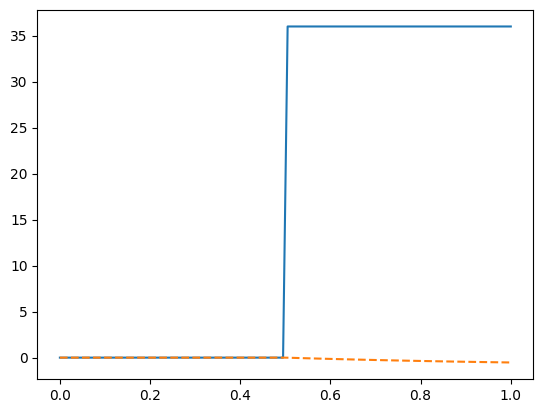

In [2]:
# Define the overall layout of the system

propulsion = ct.interconnect(
    [
        ct.rss(name="propeller", inputs=("w"), outputs=("Q")),
        ct.rss(name="transmission", inputs=("wi", "Qo"), outputs=("wo", "Qi")),
        ct.rss(name="motor", inputs=("V", "Q"), outputs=("I", "w"), states=("I", "w")),
        ct.rss(name="esc", inputs=("D", "Vi", "Io"), outputs=("Vo", "Ii")),
    ],
    name="propulsion",
    connections=[
        ["propeller.w", "transmission.wo"], ["transmission.Qo", "propeller.Q"],  # Transmission to Propeller
        ["transmission.wi", "motor.w"], ["motor.Q", "transmission.Qi"],  # Motor to Transmission
        ["motor.V", "esc.Vo"], ["esc.Io", "motor.I"],  # ESC to Motor
    ],
    inplist=["esc.D", "esc.Vi"],
    inputs=["D", "Vi"],
    outlist=["esc.Ii", "motor.w"],
    outputs=["Ii", "w"],
)
display(propulsion.__dict__)

T = np.linspace(0, 1, 100)
esc_D = np.array(
    [
        [0] * (len(T) // 2),
        [1] * (len(T) // 2),
    ]
).ravel()
esc_Vi = np.ones_like(T) * 36
U = [esc_D, esc_Vi]

T, yout = ct.input_output_response(
    propulsion, T=T, U=U, solve_ivp_kwargs={"method": "Radau"}
)

plt.plot(T, U[0] * esc_Vi)
plt.plot(T, yout[0], "--")
plt.show()


In [3]:
tzinfo = timezone("America/Sao_Paulo")

events = [
    {
        "name": "01.Curta",
        "start": pd.Timestamp(
            year=2020, month=1, day=29, hour=13, minute=51, second=59, tzinfo=tzinfo
        ),
        "end": pd.Timestamp(
            year=2020, month=1, day=29, hour=14, minute=20, second=25, tzinfo=tzinfo
        ),
    },
    {
        "name": "02.Longa",
        "start": pd.Timestamp(
            year=2020, month=1, day=30, hour=11, minute=16, second=45, tzinfo=tzinfo
        ),
        "end": pd.Timestamp(
            year=2020, month=1, day=30, hour=14, minute=55, second=30, tzinfo=tzinfo
        ),
    },
    {
        "name": "03.Revezamento",
        "start": pd.Timestamp(
            year=2020, month=1, day=31, hour=11, minute=23, second=23, tzinfo=tzinfo
        ),
        "end": pd.Timestamp(
            year=2020, month=1, day=31, hour=12, minute=27, second=23, tzinfo=tzinfo
        ),
    },
    {
        "name": "04.Curta",
        "start": pd.Timestamp(
            year=2020, month=2, day=1, hour=10, minute=15, second=15, tzinfo=tzinfo
        ),
        "end": pd.Timestamp(
            year=2020, month=2, day=1, hour=11, minute=37, second=28, tzinfo=tzinfo
        ),
    },
    {
        "name": "05.Curta",
        "start": pd.Timestamp(
            year=2020, month=2, day=1, hour=13, minute=15, second=9, tzinfo=tzinfo
        ),
        "end": pd.Timestamp(
            year=2020, month=2, day=1, hour=13, minute=32, second=55, tzinfo=tzinfo
        ),
    },
    {
        "name": "07.Sprint",
        "start": pd.Timestamp(
            year=2020, month=2, day=2, hour=11, minute=58, second=27, tzinfo=tzinfo
        ),
        "end": pd.Timestamp(
            year=2020, month=2, day=2, hour=11, minute=59, second=9, tzinfo=tzinfo
        ),
    },
]

events = pd.DataFrame(events).set_index('name')
events

,start,end
name,,
01.Curta,2020-01-29 13:51:59-03:00,2020-01-29 14:20:25-03:00
02.Longa,2020-01-30 11:16:45-03:00,2020-01-30 14:55:30-03:00
03.Revezamento,2020-01-31 11:23:23-03:00,2020-01-31 12:27:23-03:00
04.Curta,2020-02-01 10:15:15-03:00,2020-02-01 11:37:28-03:00
05.Curta,2020-02-01 13:15:09-03:00,2020-02-01 13:32:55-03:00
07.Sprint,2020-02-02 11:58:27-03:00,2020-02-02 11:59:09-03:00


'original columns:'

Index(['Battery Pack Voltage', 'Pilot Duty Cycle', 'Pilot Motor On',
       'Pilot Boat On', 'ESC Duty Cycle', 'Motor Angular Speed',
       'MPPT 1 Input Voltage', 'MPPT 2 Input Voltage', 'MPPT 3 Input Voltage',
       'MPPT 4 Input Voltage', 'MPPT 1 Output Voltage',
       'MPPT 2 Output Voltage', 'MPPT 3 Output Voltage',
       'MPPT 4 Output Voltage', 'MPPT 1 Input Current', 'MPPT 2 Input Current',
       'MPPT 3 Input Current', 'MPPT 4 Input Current', 'MPPT 1 Duty Cycle',
       'MPPT 2 Duty Cycle', 'MPPT 3 Duty Cycle', 'MPPT 4 Duty Cycle',
       'MPPT 1 Input Power', 'MPPT 2 Input Power', 'MPPT 3 Input Power',
       'MPPT 4 Input Power', 'MPPTs Input Power', 'MPPT 1 Output Current',
       'MPPT 2 Output Current', 'MPPT 3 Output Current',
       'MPPT 4 Output Current', 'MPPTs Output Current', 'MPPT 1 Output Power',
       'MPPT 2 Output Power', 'MPPT 3 Output Power', 'MPPT 4 Output Power',
       'MPPTs Output Power', 'Battery Current', 'Battery Power',
       'ESC Input Curre

'renamed columns:'

{'Battery Pack Voltage': 'batt_v',
 'Battery Current': 'batt_i',
 'ESC Duty Cycle': 'esc_dt',
 'Motor Angular Speed': 'motor_w',
 'ESC Input Power': 'esc_p_in',
 'ESC Input Current': 'esc_i_in'}

'selected columns:'

Index(['batt_v', 'batt_i', 'esc_dt', 'motor_w', 'esc_p_in', 'esc_i_in'], dtype='object')

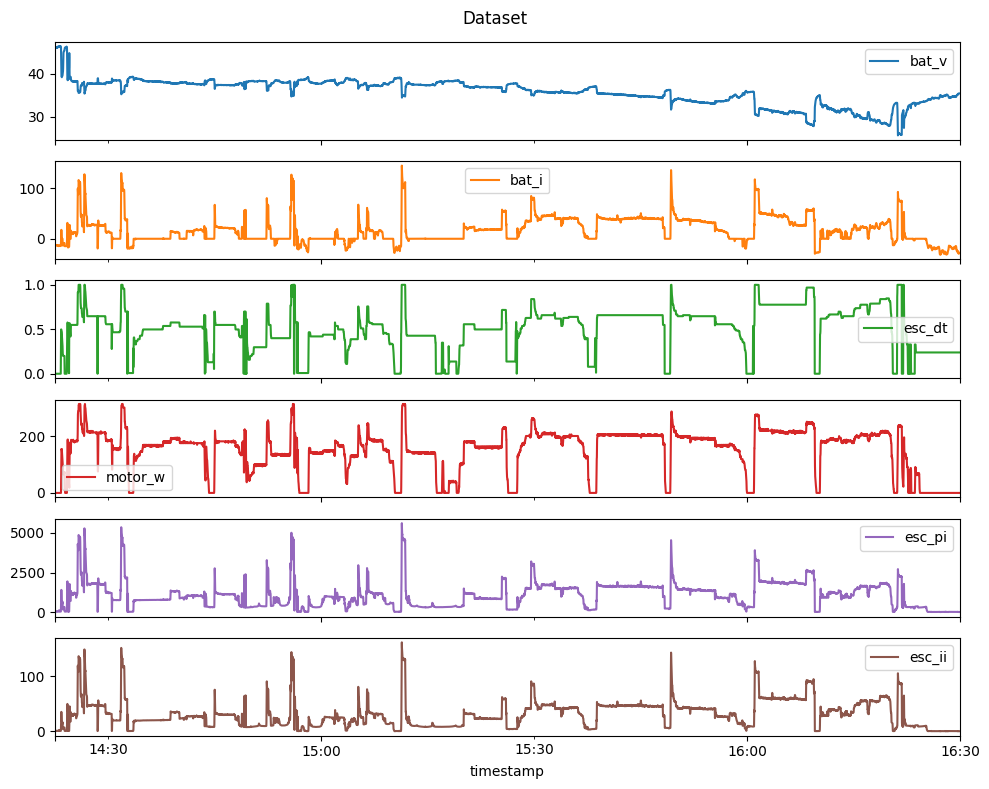

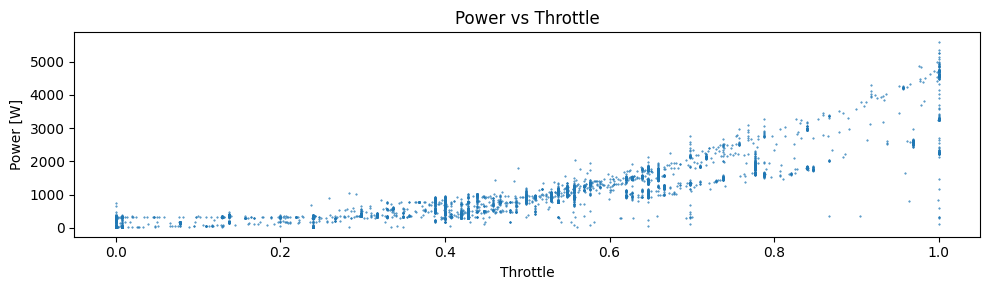

In [26]:
# From Revezamento
start = pd.Timestamp(
    year=2020, month=1, day=31, hour=11, minute=22, second=30, tzinfo=tzinfo
).tz_convert(None)
end = pd.Timestamp(
    year=2020, month=1, day=31, hour=13, minute=30, second=0, tzinfo=tzinfo
).tz_convert(None)

df = vaex.from_csv("../../../models/2020/boat_data_1s.csv").to_pandas_df()
# df = vaex.from_csv("../../../models/2020/boat_data_100ms.csv").to_pandas_df()
df["timestamp"] = pd.DatetimeIndex(df["timestamp"]).tz_convert(None)
df = df.set_index("timestamp")
display('original columns:', df.columns)

renamed_columns = {
    'Battery Pack Voltage': 'batt_v',
    'Battery Current': 'batt_i',
    'ESC Duty Cycle': 'esc_dt',
    'Motor Angular Speed': 'motor_w',
    'ESC Input Power': 'esc_p_in',
    'ESC Input Current': 'esc_i_in',
}
display('renamed columns:', renamed_columns)

df = df.loc[
    (df.index >= start) & (df.index <= end),
    renamed_columns.keys(),
].rename(columns=renamed_columns)

display('selected columns:', df.columns)

df = df.interpolate(method="time")
df = df.resample('1s').ffill()

df.plot(subplots=True, figsize=(10, 8))
plt.suptitle('Dataset')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3))
plt.title('Power vs Throttle')
plt.xlabel('Throttle')
plt.ylabel('Power [W]')
plt.scatter(df['esc_dt'], df['esc_p_in'], s=0.2)
plt.tight_layout()
plt.show()


{'name': 'propeller',
 'ninputs': 1,
 'input_index': {'w': 0},
 'noutputs': 1,
 'output_index': {'Q': 0},
 'nstates': 0,
 'state_index': {},
 'dt': 0,
 'params': {'prop_K': 0.0016229208372061088, 'prop_D': 0.2286, 'rho': 1025},
 'updfcn': None,
 'outfcn': <bound method NonlinearPropeller._outputs of <class '__main__.NonlinearPropeller'>>,
 '_current_params': {'prop_K': 0.0016229208372061088,
  'prop_D': 0.2286,
  'rho': 1025}}

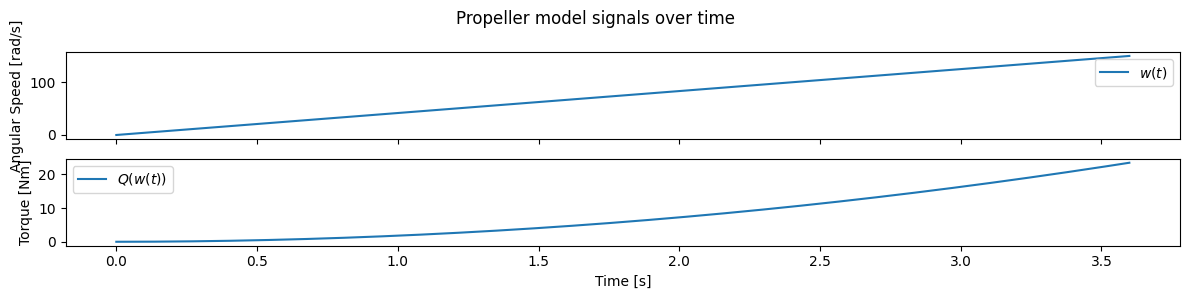

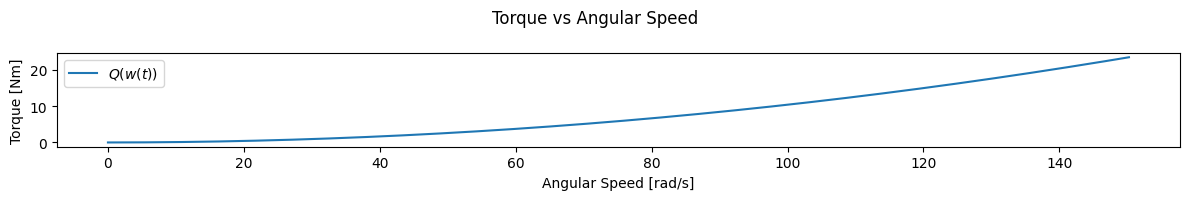

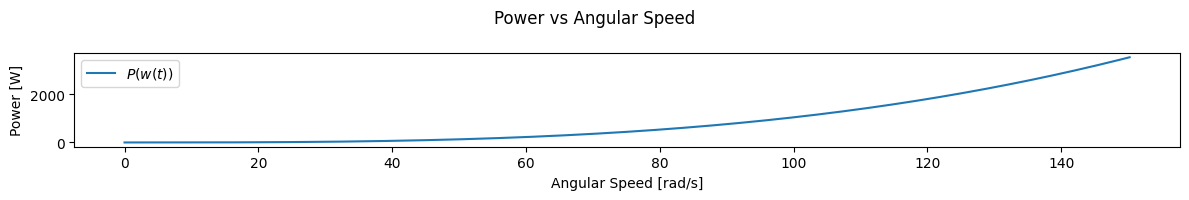

In [5]:
class NonlinearPropeller:
    @classmethod
    def _outputs(cls, t, x, u, params: dict):
        # Get the parameter values
        prop_K = params["prop_K"]
        prop_D = params["prop_D"]
        rho = params["rho"]

        # Get the inputs
        prop_w = u

        # Returns the Torque required by the Propeller
        return (prop_D * prop_D * prop_D * prop_D * prop_D) * rho * prop_K * (prop_w * prop_w)

    @classmethod
    def build(cls, params: dict):
        return ct.NonlinearIOSystem(
            None,
            cls._outputs,
            name="propeller",
            states=None,
            inputs="w",
            outputs="Q",
            params=params,
        )

# Initial guess
trans_eta = 0.95  # Rough estimation
trans_K = 13/22  # From gear teeth count
motor_K = 0.10361811  # From performance curves
esc_eta = 0.8  # From measured data
esc_vo = (df['batt_v'] * df['esc_dt']).mean()
esc_p_out = df['esc_p_in'].mean() * esc_eta
motor_I = esc_p_out / esc_vo
motor_Q = motor_K * motor_I
motor_w = df['motor_w'].mean()
prop_Q = motor_Q * trans_eta / trans_K
prop_D = 9 * 0.0254  # From the nominal propeller dimensions, it's about 70% of the measured
rho = 1025  # 20°C
prop_w = motor_w * trans_K
prop_K = (prop_Q / (prop_D**5 * rho * prop_w**2))

propeller = NonlinearPropeller.build({"prop_K": prop_K, "prop_D": prop_D, "rho": rho})
display(propeller.__dict__)

T = np.arange(0, 3600) / 1000
prop_w = np.linspace(0, df['motor_w'].mean(), len(T))

res = ct.input_output_response(
    propeller, T=T, U=prop_w, solve_ivp_kwargs={"method": "Radau"}
)
res.output_labels = propeller.output_labels
res.input_labels = propeller.input_labels
res.state_labels = propeller.state_labels
outputs_nonlinear_propeller = res.to_pandas().set_index("time")

fig, ax = plt.subplots(2,1,figsize=(12, 3), sharex=True)
ax[0].plot(outputs_nonlinear_propeller["w"], label="$w(t)$")
ax[0].set_ylabel("Angular Speed [rad/s]")
ax[0].legend(loc=0)
ax[1].plot(outputs_nonlinear_propeller["Q"], label="$Q(w(t))$")
ax[1].set_ylabel("Torque [Nm]")
ax[1].set_xlabel("Time [s]")
ax[1].legend(loc=0)
plt.suptitle("Propeller model signals over time")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 2))
plt.plot(outputs_nonlinear_propeller['w'], outputs_nonlinear_propeller['Q'], label="$Q(w(t))$")
plt.xlabel("Angular Speed [rad/s]")
plt.ylabel("Torque [Nm]")
plt.suptitle("Torque vs Angular Speed")
plt.legend(loc=0)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 2))
plt.plot(outputs_nonlinear_propeller['w'], outputs_nonlinear_propeller['w']*outputs_nonlinear_propeller['Q'], label="$P(w(t))$")
plt.xlabel("Angular Speed [rad/s]")
plt.ylabel("Power [W]")
plt.suptitle("Power vs Angular Speed")
plt.legend(loc=0)
plt.tight_layout()
plt.show()

{'name': 'propeller',
 'ninputs': 1,
 'input_index': {'w': 0},
 'noutputs': 1,
 'output_index': {'Q': 0},
 'nstates': 2,
 'state_index': {'x[0]': 0, 'x[1]': 1},
 'dt': 0,
 'params': {},
 'A': array([[0., 1.],
        [0., 0.]]),
 'B': array([[0.        ],
        [0.09219074]]),
 'C': array([[1., 0.]]),
 'D': array([[0.]])}

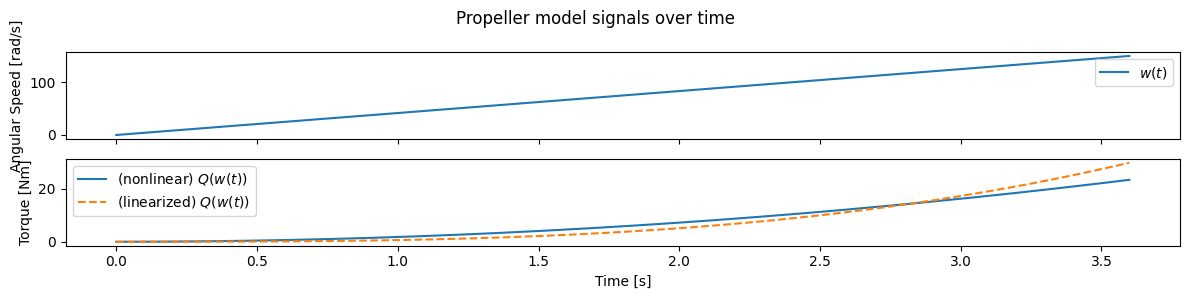

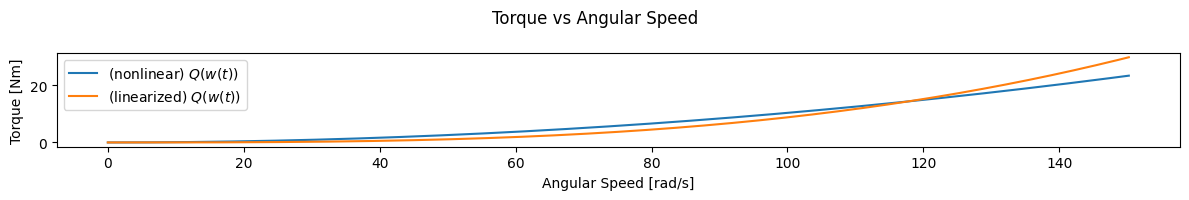

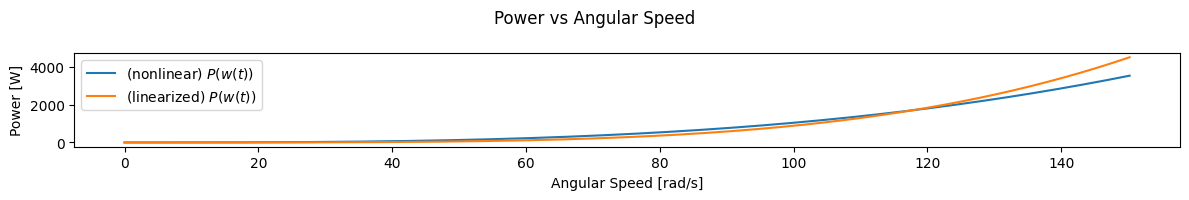

In [6]:
class LinearPropeller:
    @classmethod
    def build(cls, params: dict):
        # Get the parameter values
        prop_K = params["prop_K"]
        prop_D = params["prop_D"]
        rho = params["rho"]
        prop_w0 = params["prop_w0"]   # linearization point

        A = np.array([
            [0, 1],
            [0, 0],
        ])
        B = np.array([
            [0],
            [2 * prop_K * rho * prop_D**5 * prop_w0],
        ])
        C = np.array([
            [1, 0],
        ])
        D = np.array([0])

        return ct.ss(
            A,
            B,
            C,
            D,
            name="propeller",
            # states=None,
            inputs="w",
            outputs="Q",
        )

# Initial guess
trans_eta = 0.95  # Rough estimation
trans_K = 13/22  # From gear teeth count
motor_K = 0.10361811  # From performance curves
esc_eta = 0.8  # From measured data
esc_vo = (df['batt_v'] * df['esc_dt']).mean()
esc_p_out = df['esc_p_in'].mean() * esc_eta
motor_I = esc_p_out / esc_vo
motor_Q = motor_K * motor_I
motor_w = df['motor_w'].mean()
prop_Q = motor_Q * trans_eta / trans_K
prop_D = 8.5 * 0.0254  # From the nominal propeller dimensions, it's about 70% of the measured
rho = 1025  # 20°C
prop_w = motor_w * trans_K
prop_K = (prop_Q / (prop_D**5 * rho * prop_w**2))
prop_w0 = prop_w.mean()/2 # linearization point

propeller = LinearPropeller.build({"prop_K": prop_K, "prop_D": prop_D, "rho": rho, "prop_w0": prop_w0})
display(propeller.__dict__)

T = np.arange(0, 3600) / 1000
prop_w = np.linspace(0, df['motor_w'].mean(), len(T))

res = ct.input_output_response(
    propeller, T=T, U=prop_w, solve_ivp_kwargs={"method": "Radau"}
)
res.output_labels = propeller.output_labels
res.input_labels = propeller.input_labels
res.state_labels = propeller.state_labels
outputs_linear_propeller = res.to_pandas().set_index("time")

fig, ax = plt.subplots(2,1,figsize=(12, 3), sharex=True)
ax[0].plot(outputs_linear_propeller["w"], label="$w(t)$")
ax[0].set_ylabel("Angular Speed [rad/s]")
ax[0].legend(loc=0)
ax[1].plot(outputs_nonlinear_propeller["Q"], label="(nonlinear) $Q(w(t))$")
ax[1].plot(outputs_linear_propeller["Q"], '--', label="(linearized) $Q(w(t))$")
ax[1].set_ylabel("Torque [Nm]")
ax[1].set_xlabel("Time [s]")
ax[1].legend(loc=0)
plt.suptitle("Propeller model signals over time")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 2))
plt.plot(outputs_nonlinear_propeller['w'], outputs_nonlinear_propeller['Q'], label="(nonlinear) $Q(w(t))$")
plt.plot(outputs_linear_propeller['w'], outputs_linear_propeller['Q'], label="(linearized) $Q(w(t))$")
plt.xlabel("Angular Speed [rad/s]")
plt.ylabel("Torque [Nm]")
plt.suptitle("Torque vs Angular Speed")
plt.legend(loc=0)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 2))
plt.plot(outputs_nonlinear_propeller['w'], outputs_nonlinear_propeller['w']*outputs_nonlinear_propeller['Q'], label="(nonlinear) $P(w(t))$")
plt.plot(outputs_linear_propeller['w'], outputs_linear_propeller['w']*outputs_linear_propeller['Q'], label="(linearized) $P(w(t))$")
plt.xlabel("Angular Speed [rad/s]")
plt.ylabel("Power [W]")
plt.suptitle("Power vs Angular Speed")
plt.legend(loc=0)
plt.tight_layout()
plt.show()

Propeller = LinearPropeller

In [7]:
class Transmission:
    @classmethod
    def _outputs(cls, t, x, u, params: dict):
        # Get the parameter values
        trans_eta = params["trans_eta"]
        trans_K = params["trans_K"]  # gear ratio as `output speed / input speed`

        # Get the inputs
        trans_w_in = u[0]
        trans_Qo = u[1]

        #
        trans_w_out = trans_w_in * trans_K
        trans_Qi = trans_Qo * trans_K / trans_eta

        return (trans_w_out, trans_Qi)

    @classmethod
    def build(cls, params: dict):
        return ct.NonlinearIOSystem(
            None,
            cls._outputs,
            name="transmission",
            states=None,
            inputs=("wi", "Qo"),
            outputs=("wo", "Qi"),
            params=params,
        )

trans_eta = 0.95
trans_K = 13/22

transmission = Transmission.build({"trans_eta": trans_eta, "trans_K": trans_K})
display(transmission.__dict__)


{'name': 'transmission',
 'ninputs': 2,
 'input_index': {'wi': 0, 'Qo': 1},
 'noutputs': 2,
 'output_index': {'wo': 0, 'Qi': 1},
 'nstates': 0,
 'state_index': {},
 'dt': 0,
 'params': {'trans_eta': 0.95, 'trans_k': 0.5909090909090909},
 'updfcn': None,
 'outfcn': <bound method Transmission._outputs of <class '__main__.Transmission'>>,
 '_current_params': {'trans_eta': 0.95, 'trans_k': 0.5909090909090909}}

{'motor_R': 0.033,
 'motor_L': 0.001,
 'motor_B': 0.004107378189919799,
 'motor_I_r': 0.039200000000000006,
 'motor_K': 0.10596697039485706,
 'motor_I_r_load': 0}

{'name': 'motor',
 'ninputs': 2,
 'input_index': {'V': 0, 'Q': 1},
 'noutputs': 2,
 'output_index': {'I': 0, 'w': 1},
 'nstates': 2,
 'state_index': {'I': 0, 'w': 1},
 'dt': 0,
 'params': {},
 'A': array([[-3.30000000e+01, -1.05966970e+02],
        [ 2.70323904e+00, -1.04780056e-01]]),
 'B': array([[1000.        ,    0.        ],
        [   0.        ,  -25.51020408]]),
 'C': array([[1., 0.],
        [0., 1.]]),
 'D': array([[0., 0.],
        [0., 0.]])}

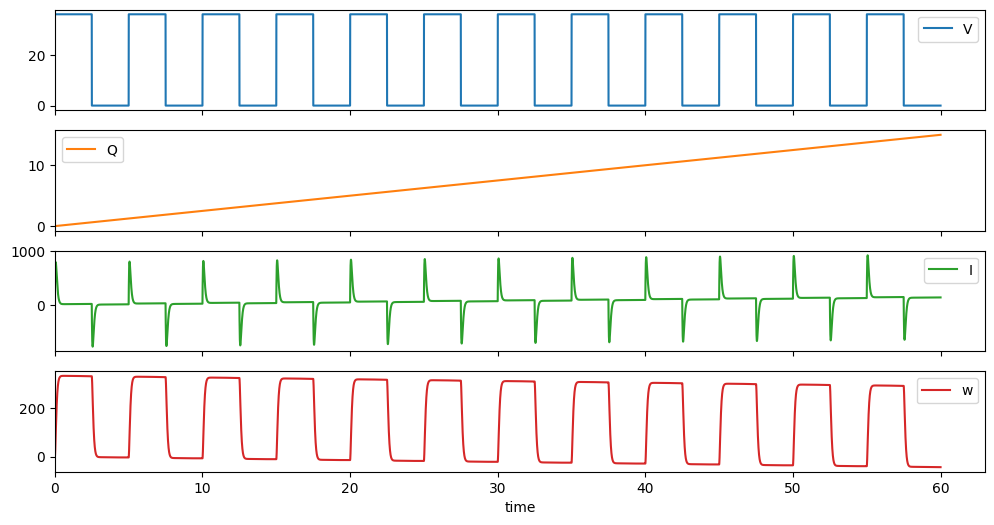

In [8]:
from scipy import signal

class Motor:
    @classmethod
    def build(cls, params: dict):
        motor_K = params["motor_K"]
        motor_R = params["motor_R"]
        motor_L = params["motor_L"]
        motor_I_r = params["motor_I_r"]
        motor_B = params["motor_B"]
        motor_I_r_load = params["motor_I_r_load"]
        motor_I_r_total = motor_I_r + motor_I_r_load

        # From:
        #   didt = (-motor_R*motor_i -motor_K*motor_w + motor_v) / motor_L
        #   dwdt = (motor_K*motor_i -motor_B*motor_w - motor_Q) / motor_I_r_total
        # Considering:
        #   X = [motor_I, motor_w]
        #   U = [motor_V, motor_Q]
        #   Y = [motor_I, motor_w]

        # State Transition matrix, shape 'n,n' -> '2x2'
        A = np.array(
            [
                [-motor_R / motor_L, -motor_K / motor_L],
                [+motor_K / motor_I_r_total, -motor_B / motor_I_r_total],
            ],
        )

        # Input matrix, shape 'n,m' -> '2x2'
        B = np.array(
            [
                [+1 / motor_L, 0],
                [0, -1 / motor_I_r_total],
            ],
        )

        # Output matrix, shape 'p,n' -> '3x2'
        C = np.array(
            [
                [1, 0],
                [0, 1],
            ],
        )

        # Remaining matrix, shape 'p,m' -> '3x2'
        D = np.array(
            [
                [0, 0],
                [0, 0],
            ],
        )

        return ct.ss(
            A,
            B,
            C,
            D,
            name="motor",
            states=("I", "w"),
            inputs=("V", "Q"),
            outputs=("I", "w"),
        )

# Initial guess
motor_V = (df['batt_v'] * df['esc_dt']).mean()
motor_R = 0.033  # Estimation
# Considering steady-state and zero load torque and solving for motor_K:
#   dwdt = (-motor_B*motor_w + motor_K*motor_i - motor_Q) / motor_I_r
#   didt = (-motor_K*motor_w - motor_R*motor_i + motor_v) / motor_L
motor_K = (motor_V - (motor_I * motor_R)) / motor_w
motor_eta = 0.8  # Averaged from the performance curves
motor_Pi = motor_V * motor_I
# Considering:
#   motor_Ple = motor_R*motor_I**2
#   motor_Plm = motor_B*motor_w**2
#   motor_Pl = motor_Ple + motor_Plm
#   motor_Po = motor_Pi * motor_eta = motor_Pi - motor_Pl
motor_B = ((motor_Pi -motor_Pi*motor_eta) - motor_R*motor_I**2)/motor_w**2
motor_L = 1e-03  # Unknown
motor_rotor_radius = (14/2)/100  # meters
motor_rotor_mass = 8  # kg
motor_I_r = motor_rotor_mass * motor_rotor_radius**2

params = {"motor_R": motor_R, "motor_L": motor_L, "motor_B": motor_B, "motor_I_r": motor_I_r, "motor_K": motor_K, "motor_I_r_load": 0}
display(params)
motor = Motor.build(params)
display(motor.__dict__)

Tend = 60
freq = int(10e3)
T = np.linspace(0, Tend, freq*5)
motor_V = np.ones_like(T) * 36  # Input voltage
motor_Q_load = np.linspace(0, 15, len(T))  # Load torque
D = 0.5  # Duty-cycle
motor_V = (signal.square(2 * np.pi * freq * T, D) + 1) * 0.5 * 36

res = ct.forced_response(motor, T, U=[motor_V, motor_Q_load], X0=[0, 0])
res.output_labels = motor.output_labels
res.input_labels = motor.input_labels
res.state_labels = motor.state_labels
outputs = res.to_pandas().set_index("time")
outputs.plot(subplots=True, figsize=(12, 6))
plt.xlim((0))
plt.show()


{'name': 'esc',
 'ninputs': 3,
 'input_index': {'D': 0, 'Vi': 1, 'Io': 2},
 'noutputs': 2,
 'output_index': {'Vo': 0, 'Ii': 1},
 'nstates': 0,
 'state_index': {},
 'dt': 0,
 'params': {'esc_eta': 0.8},
 'updfcn': None,
 'outfcn': <bound method ESC._outputs of <class '__main__.ESC'>>,
 '_current_params': {'esc_eta': 0.8}}

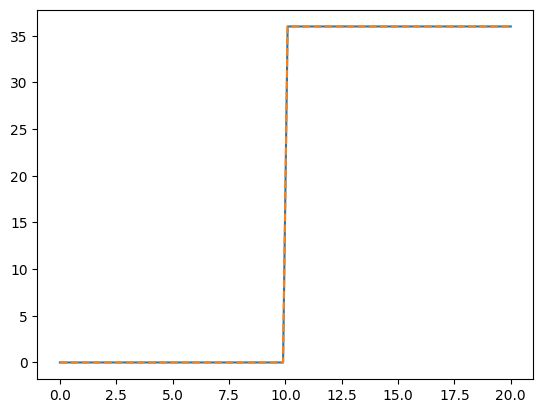

In [9]:
class ESC:
    @classmethod
    def _outputs(cls, t, x, u, params: dict):
        esc_eta = params['esc_eta']

        # Get the inputs
        esc_D = u[0]
        esc_Vi = u[1]
        esc_Io = u[2]

        # Saturate esc_D
        esc_D = np.clip(esc_D, 0, 1)

        #
        esc_Vo = esc_D * esc_Vi
        esc_Ii = esc_Io * esc_D / esc_eta

        return (esc_Vo, esc_Ii)

    @classmethod
    def build(cls, params: dict = {}):
        return ct.NonlinearIOSystem(
            None,
            cls._outputs,
            name="esc",
            states=None,
            inputs=("D", "Vi", "Io"),
            outputs=("Vo", "Ii"),
            params=params,
        )

esc_eta = 0.8

sys = ESC.build({"esc_eta": esc_eta})
display(sys.__dict__)

T = np.linspace(0, 20, 100)
esc_D = np.array(
    [
        [0] * (len(T) // 2),
        [1] * (len(T) // 2),
    ]
).ravel()
esc_Vi = np.ones_like(T) * 36
esc_Io = np.zeros_like(T)
U = [esc_D, esc_Vi, esc_Io]

T, yout = ct.input_output_response(sys, T, U)

plt.plot(T, U[0] * esc_Vi)
plt.plot(T, yout[0], "--")
plt.show()


name,value,initial value,min,max,vary
motor_R,0.03300000,0.033,0.01650000,0.04950000,False
motor_L,0.50000000,0.5,0.25000000,0.75000000,False
motor_B,0.00410738,0.004107378189919799,0.00205369,0.00616107,False
motor_I_r,0.03920000,0.039200000000000006,0.01960000,0.05880000,False
motor_I_r_load,0.00780765,0.007807645674999999,0.00390382,0.01171147,False
motor_K,0.10596697,0.10596697039485706,0.05298349,0.15895046,False
prop_K,0.00150000,0.0015,7.5000e-04,0.00225000,False
prop_D,0.21590000,0.21589999999999998,0.10795000,0.32385000,False
rho,1025.00000,1025,512.500000,1537.50000,False
trans_eta,0.95000000,0.95,0.47500000,1.42500000,False


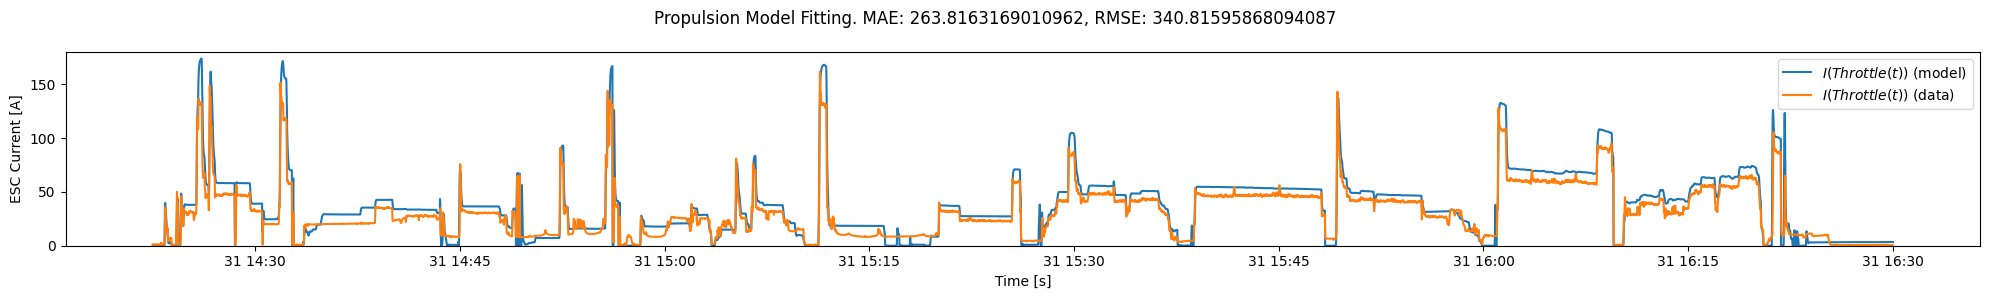

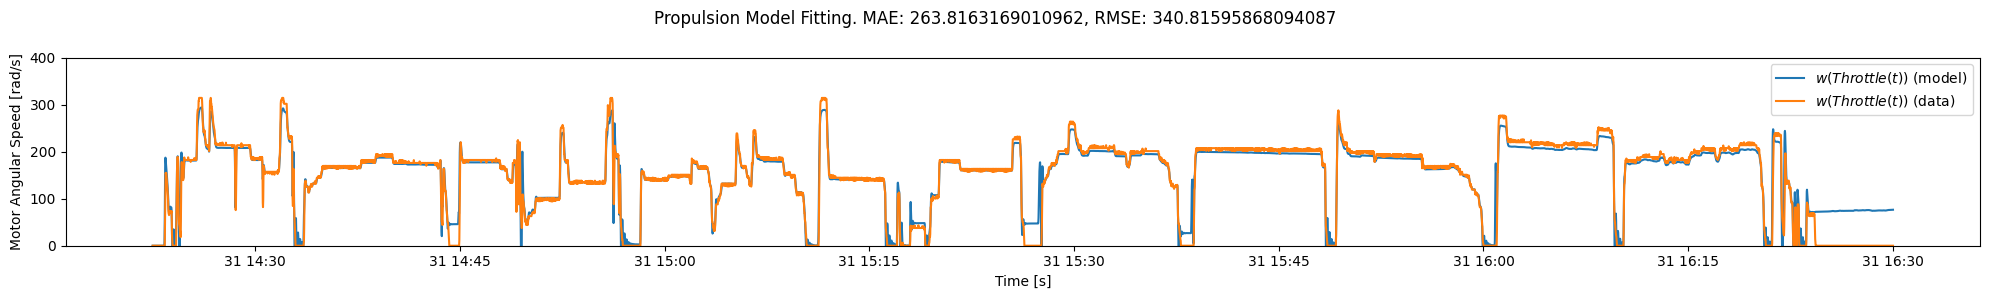

In [10]:
Propeller = NonlinearPropeller

class Propulsion:
    @classmethod
    def build(cls, params: dict):
        return ct.interconnect(
            (
                Propeller.build(params),
                Transmission.build(params),
                Motor.build(params),
                ESC.build(params),
            ),
            name="propulsion",
            connections=[
                ["propeller.w", "transmission.wo"], ["transmission.Qo", "propeller.Q"],  # Transmission to Propeller
                ["transmission.wi", "motor.w"], ["motor.Q", "transmission.Qi"],  # Motor to Transmission
                ["motor.V", "esc.Vo"], ["esc.Io", "motor.I"],  # ESC to Motor
            ],
            inplist=["esc.D", "esc.Vi"],
            inputs=["D", "Vi"],
            outlist=["esc.Ii", "motor.w"],
            outputs=["Ii", "w"],
        )

# Missing initial Guess
prop_mass = 0.67  # kg
motor_I_r_load = prop_mass*(prop_D/2)**2
motor_L = 50e-2
prop_K = 1.5e-3  # 1e-3 2e-3

# Parameters
params = lmfit.Parameters()
params.add_many(
    # NAME, VALUE, VARY, MIN,  MAX,  EXPR, BRUTE_STEP
    ("motor_R", motor_R, False, motor_R*1.5, motor_R*0.5, None, None),  # Motor Armature Resistance [Ω]
    ("motor_L", motor_L, False, motor_L*1.5, motor_L*0.5, None, None),  # Motor Armature Inductance [Henrys]
    ("motor_B", motor_B, False, motor_B*1.5, motor_B*0.5, None, None),  # Motor Mechanical Frictional coeffiecient [Nm/(rad/s)]
    ("motor_I_r", motor_I_r, False, motor_I_r*1.5, motor_I_r*0.5, None, None),  # Motor Rotor Inertial moment [Kgm²]
    ("motor_I_r_load", motor_I_r_load, False, motor_I_r_load*1.5, motor_I_r_load*0.5, None, None),  # Motor Load Inertial moment [Kgm²]
    ("motor_K", motor_K, False, motor_K*1.5, motor_K*0.5, None, None),  # Volt-revolution ratio [V/(rad/s)]
    ("prop_K", prop_K, False, prop_K*1.5, prop_K*0.5, None, None),  # Propeller torque coefficient
    ("prop_D", prop_D, False, prop_D*1.5, prop_D*0.5, None, None),  # Nominal Propeller diameter (70% of the measured diameter) [m]
    # ("prop_w0", prop_w0*0, False, prop_w0*1.5, prop_w0*0.5, None, None),  # Linearization point of Propeller [rad/s]
    ("rho", rho, False, rho*1.5, rho*0.5, None, None),  # Water density [kg/m3]
    ("trans_eta", trans_eta, False, trans_eta*1.5, trans_eta*0.5, None, None),
    ("esc_eta", esc_eta, False, esc_eta*1.5, esc_eta*0.5, None, None),
    ("trans_K", trans_K, False, trans_K*1.5, trans_K*0.5, None, None), # Transmission's gear ratio as `output speed / input speed`
)
display(params)

# Model
propulsion = Propulsion.build(params.valuesdict())
# display(propulsion.__dict__)

# Time array
T = (df.index[1] - df.index[0]).to_numpy().astype(np.float64) * 1e-9   # simulation time in seconds
lenT = len(df.index)
T = np.linspace(0, lenT * T, lenT, endpoint=False)  # Recreate the time array because of numerical issues from the index datetime to float transformation

# Data
esc_D = df["esc_dt"].to_numpy()
batt_V = df["batt_v"].to_numpy()

if True:
    # Test initial parameters
    df_init = ct.input_output_response(
        propulsion,
        T=T,
        U=[esc_D, batt_V],
        solve_ivp_method="Radau",
    ).to_pandas()

    df['esc_p_in'] = df['esc_i_in'] * df['batt_v']
    df_init['esc_p_in'] = df_init['Ii'].to_numpy() * df_init['Vi'].to_numpy()

    rmse = (((df['esc_p_in'].to_numpy() - df_init['esc_p_in'].to_numpy())**2).sum() / len(df))**(1/2)
    mae = abs(df['esc_p_in'].to_numpy() - df_init['esc_p_in'].to_numpy()).sum() / len(df)

    plt.figure(figsize=(20, 3))
    plt.plot(df.index, df_init['Ii'], label='$I(Throttle(t))$ (model)')
    plt.plot(df.index, df['esc_i_in'], label='$I(Throttle(t))$ (data)')
    plt.xlabel('Time [s]')
    plt.ylabel('ESC Current [A]')
    plt.legend(loc=1)
    plt.suptitle(f"Propulsion Model Fitting. MAE: {mae}, RMSE: {rmse}")
    plt.ylim([0,180])
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(20, 3))
    plt.plot(df.index, df_init['w'], label='$w(Throttle(t))$ (model)')
    plt.plot(df.index, df['motor_w'], label='$w(Throttle(t))$ (data)')
    plt.xlabel('Time [s]')
    plt.ylabel('Motor Angular Speed [rad/s]')
    plt.legend(loc=1)
    plt.suptitle(f"Propulsion Model Fitting. MAE: {mae}, RMSE: {rmse}")
    plt.ylim([0,400])
    plt.tight_layout()
    plt.show()

name,value,initial value,min,max,vary
motor_R,0.03300000,0.033,0.01650000,0.04950000,False
motor_L,0.10000000,0.5,1.0000e-06,0.10000000,True
motor_B,0.00410738,0.004107378189919799,0.00205369,0.00616107,False
motor_I_r,0.03920000,0.039200000000000006,0.01960000,0.05880000,True
motor_I_r_load,0.00780765,0.007807645674999999,1.0000e-06,1.00000000,False
motor_K,0.10596697,0.10596697039485706,0.05298349,0.15895046,False
prop_K,0.00150000,0.0015,7.5000e-04,0.00225000,True
prop_D,0.21590000,0.21589999999999998,0.10795000,0.32385000,True
rho,1025.00000,1025,512.500000,1537.50000,False
trans_eta,0.95000000,0.95,0.80000000,1.00000000,False


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/optimize/_differentialevolution.py:387: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in double_scalars
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in double_scalars
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in double_scalars
  

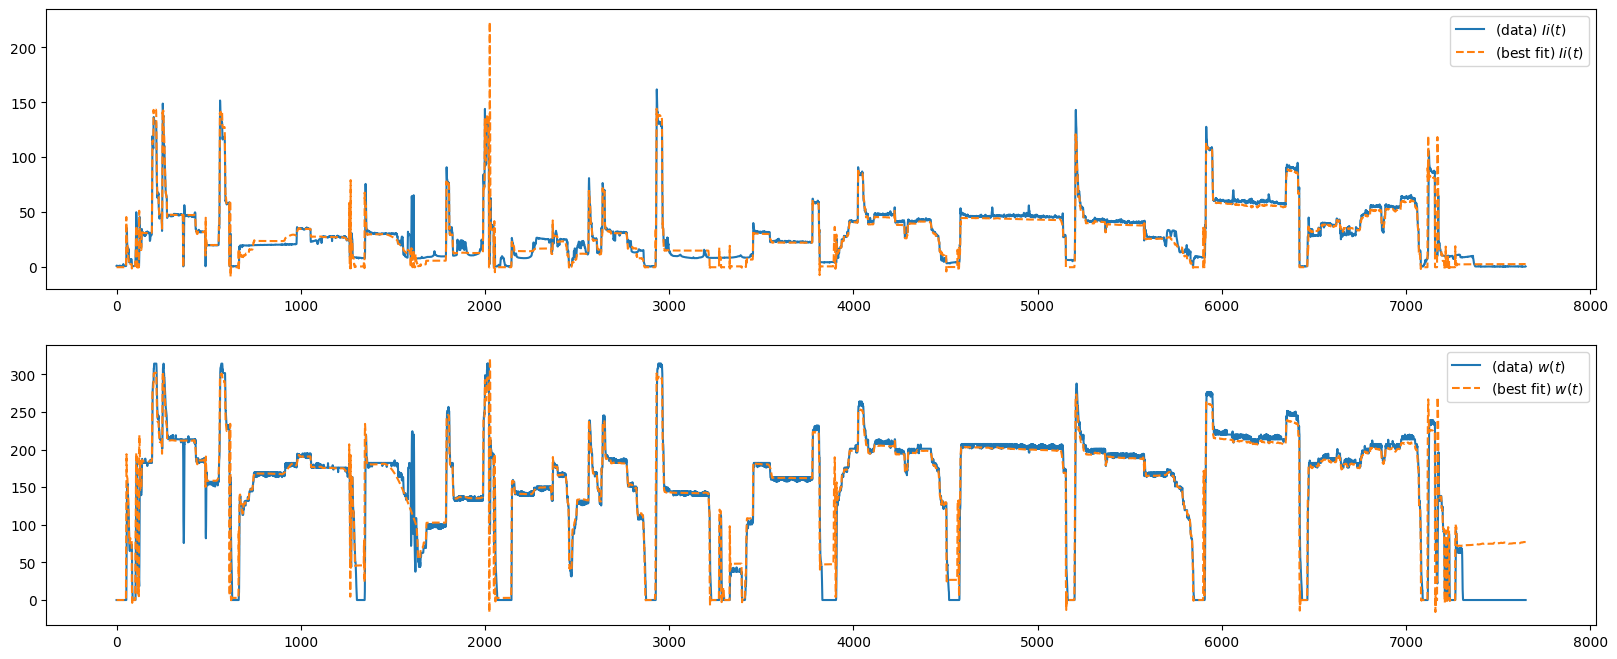

In [11]:
def func(T, U, **params):
    return ct.input_output_response(
        Propulsion.build(params),
        T=T,
        U=U,
        solve_ivp_method="Radau",
    ).to_pandas()[["Ii", "w"]].to_numpy()

# RECORD EVERY STEP
global_residuals = []
global_iters = []
global_params = []
def iter_cb(params, iter, resid, *fcn_args, **fcn_kws):
    global global_residuals
    global global_iters
    global global_params

    global_residuals += [resid]
    global_iters += [iter]
    global_params += [params.valuesdict()]


model = lmfit.Model(
    func=func,
    independent_vars=["T", "U"],
)

params = lmfit.Parameters()
motor_L_min = 1e-6
motor_L_max = 1e-1
prop_K_max = prop_K*1.5
prop_K_min = prop_K*0.5
params.add_many(
    # Important reading about stiff problems: https://github.com/scipy/scipy/issues/11698
    # NAME, VALUE, VARY, MIN,  MAX,  EXPR, BRUTE_STEP
    ('motor_R', motor_R, False, motor_R*1.5, motor_R*0.5, None, None),  # Motor Armature Resistance [Ω]
    ('motor_L', motor_L, True, motor_L_max, motor_L_min, None, None),  # Motor Armature Inductance [Henrys]
    ('motor_B', motor_B, False, motor_B*1.5, motor_B*0.5, None, None),  # Motor Mechanical Frictional coeffiecient [Nm/(rad/s)]
    ('motor_I_r', motor_I_r, True, motor_I_r*1.5, motor_I_r*0.5, None, None),  # Motor Rotor Inertial moment [Kgm²]
    ('motor_I_r_load', motor_I_r_load, False, 1e-6, 1, None, None),  # Motor Load Inertial moment [Kgm²]
    ('motor_K', motor_K, False, motor_K*1.5, motor_K*0.5, None, None),  # Volt-revolution ratio [V/(rad/s)]
    ('prop_K', prop_K, True, prop_K_max, prop_K_min, None, None),  # Propeller torque coefficient
    ('prop_D', prop_D, True, prop_D*1.5, prop_D*0.5, None, None),  # Nominal Propeller diameter (70% of the measured diameter) [m]
    ('rho', rho, False, rho*1.5, rho*0.5, None, None),  # Water density [kg/m3]
    ('trans_eta', trans_eta, False, 1.0, 0.8, None, None),
    ('esc_eta', esc_eta, False, 1.0, 0.5, None, None),
    ('trans_k', trans_K, False, trans_K*1.5, trans_K*0.5, None, None), # Transmission's gear ratio as `output speed / input speed`
)
display(params)

# Time array
T = (df.index[1] - df.index[0]).to_numpy().astype(np.float64) * 1e-9   # simulation time in seconds
lenT = len(df.index)
T = np.linspace(0, lenT * T, lenT, endpoint=False)  # Recreate the time array because of numerical issues from the index datetime to float transformation

# Inputs and Fit Data
U = df[['esc_dt', 'batt_v']].to_numpy().T
data = df[["esc_i_in", "motor_w"]].to_numpy()

result = model.fit(
    data=data,
    params=params,
    iter_cb=iter_cb,
    method='differential_evolution',
    fit_kws=dict(workers=8),
    T=T,
    U=U,
)

fig, ax = plt.subplots(2, figsize=(20, 4*2))
for i, (initial, best, data) in enumerate(
    zip(result.init_fit.T, result.best_fit.T, result.data.T)
):
    label = propulsion.output_labels[i]

    ax[i].plot(data, label=f"(data) ${label}(t)$")
    # ax[i].plot(initial, ".", label=f"(initial fit) ${label}(t)$")
    ax[i].plot(best, "--", label=f"(best fit) ${label}(t)$")
    ax[i].legend(loc=1)

plt.show()

result


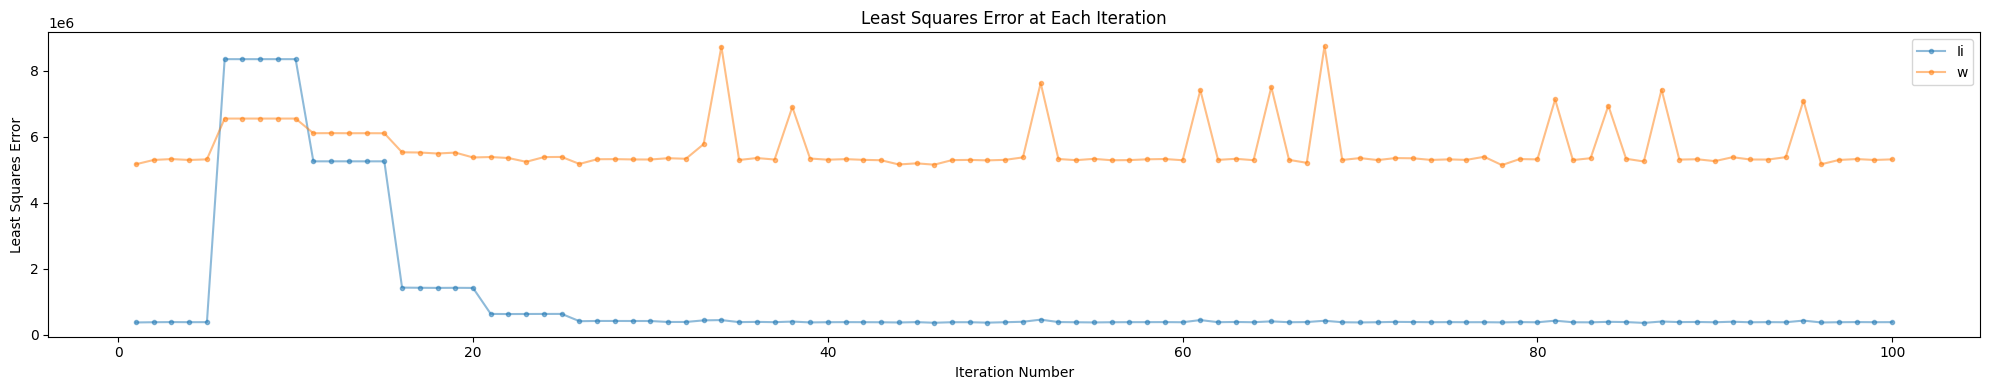

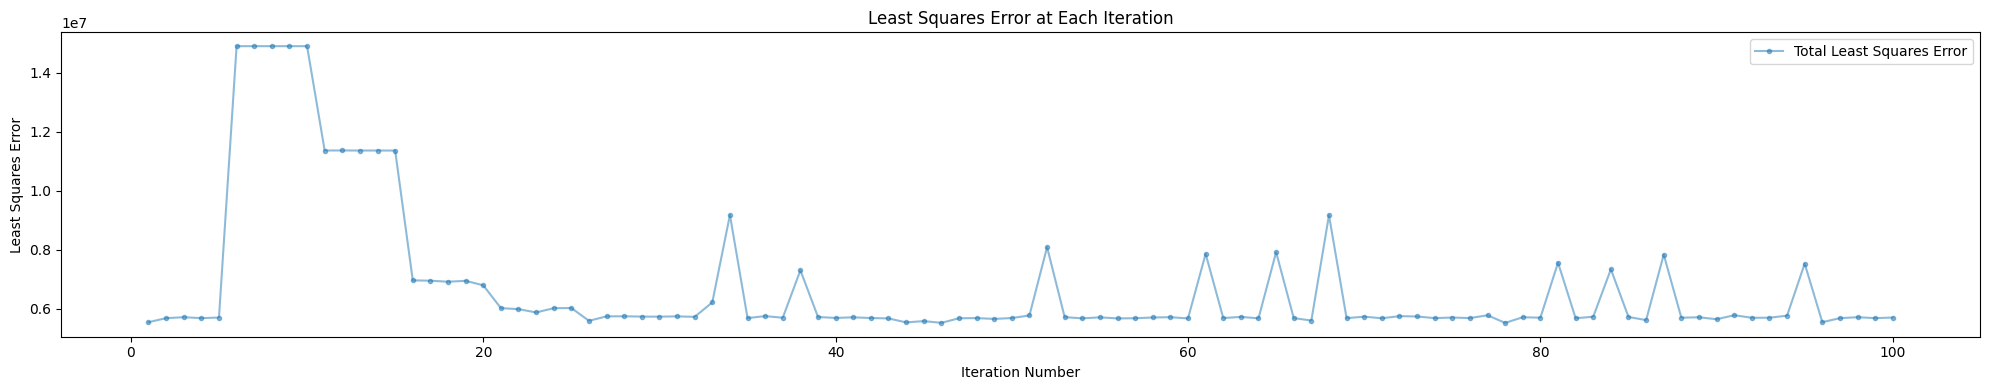

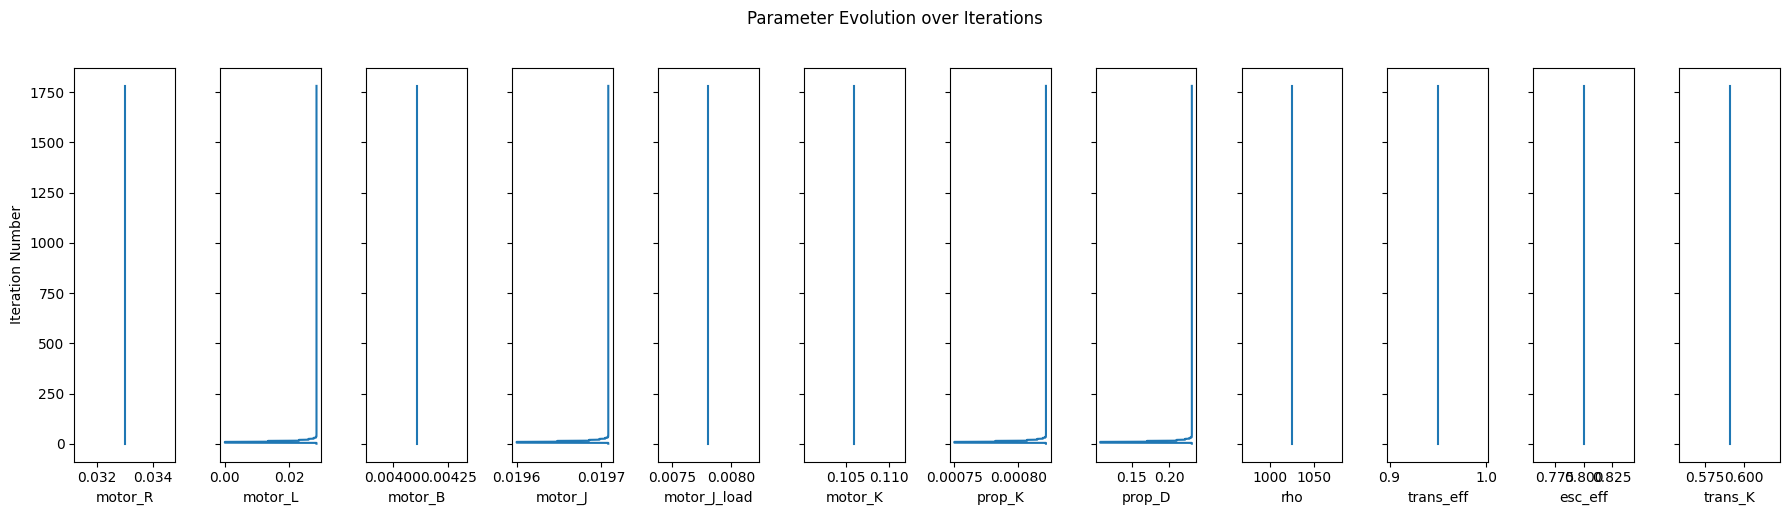

In [21]:
least_squares_errors = [np.sum(np.square(residual), axis=0) for residual in global_residuals]

plt.figure(figsize=(20,4))
plt.plot(global_iters[:-1], np.array(least_squares_errors)[:-1,0].T, marker='.', linestyle='-', alpha=0.5, label=propulsion.output_labels[0])
plt.plot(global_iters[:-1], np.array(least_squares_errors)[:-1,1].T, marker='.', linestyle='-', alpha=0.5, label=propulsion.output_labels[1])
plt.title('Least Squares Error at Each Iteration')
plt.xlabel('Iteration Number')
plt.ylabel('Least Squares Error')
plt.legend(loc=1)
plt.tight_layout()
plt.show()

least_squares_errors_total = [np.sum(np.square(residual.flatten())) for residual in global_residuals]

plt.figure(figsize=(20,4))
plt.plot(global_iters[:-1], np.array(least_squares_errors_total)[:-1].T, marker='.', linestyle='-', alpha=0.5, label='Total Least Squares Error')
plt.title('Least Squares Error at Each Iteration')
plt.xlabel('Iteration Number')
plt.ylabel('Least Squares Error')
plt.legend(loc=1)
plt.tight_layout()
plt.show()

param_names = list(global_params[0].keys())  # Assuming all steps have the same parameters

fig, axs = plt.subplots(1, len(param_names), figsize=(1.5 * len(param_names), 5), sharey=True)
# Plot each parameter value over iterations in a separate subplot
for i, param_name in enumerate(param_names):
    param_values = [step[param_name] for step in global_params]
    axs[i].plot(param_values, global_iters, label=param_name)
    axs[i].set_xlabel(param_name)
axs[0].set_ylabel('Iteration Number')
plt.suptitle('Parameter Evolution over Iterations', y=1.02)
plt.tight_layout()
plt.show()

/tmp/ipykernel_2446187/833969790.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['esc_p_in'] = df['esc_i_in'] * df['batt_v']


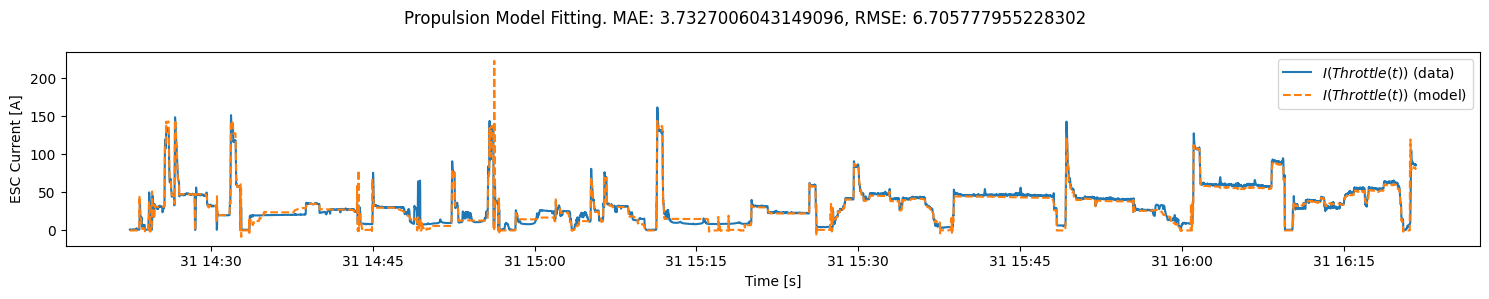

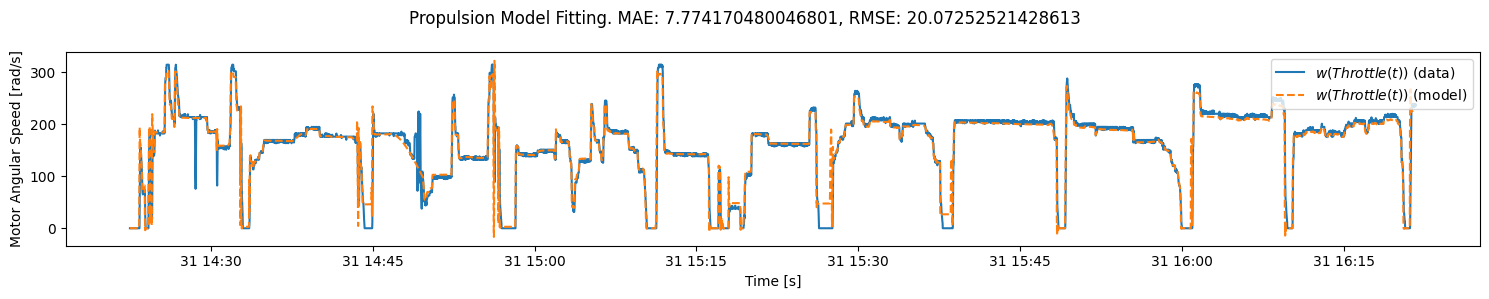

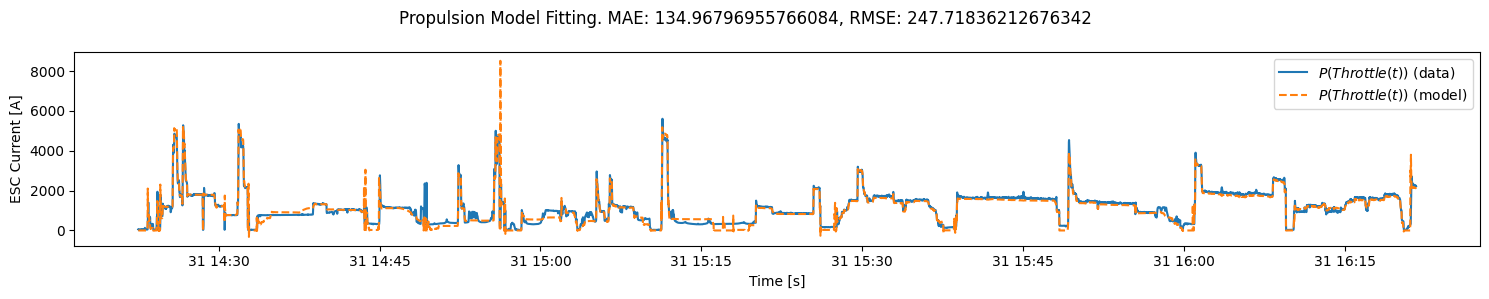

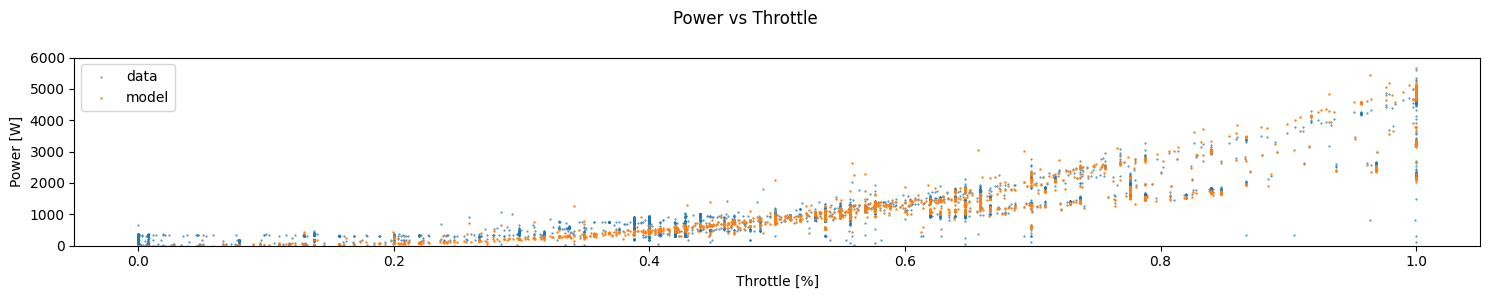

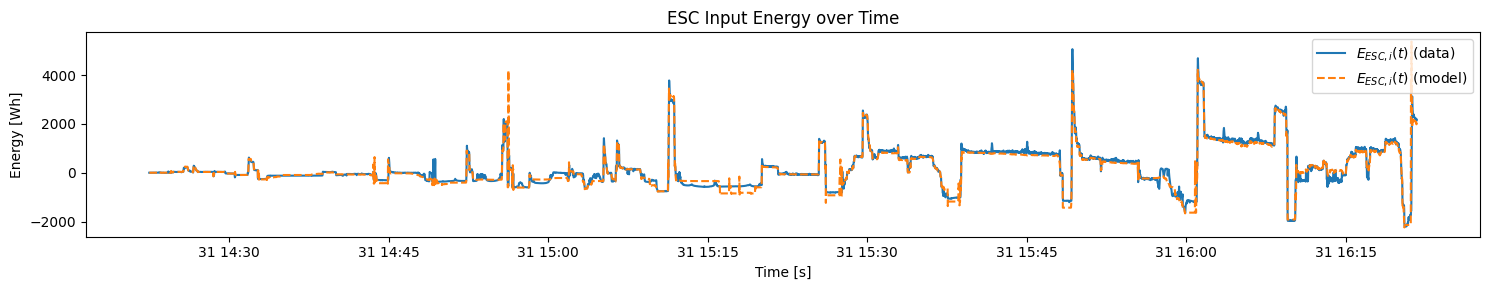

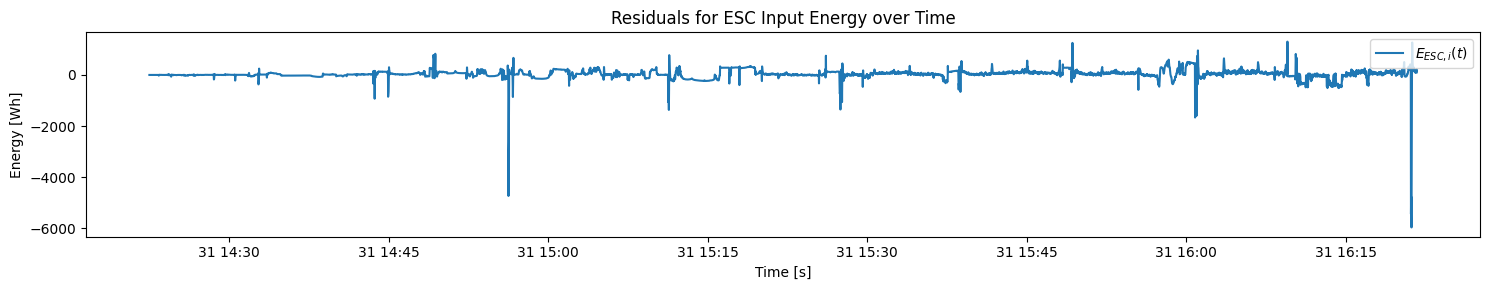

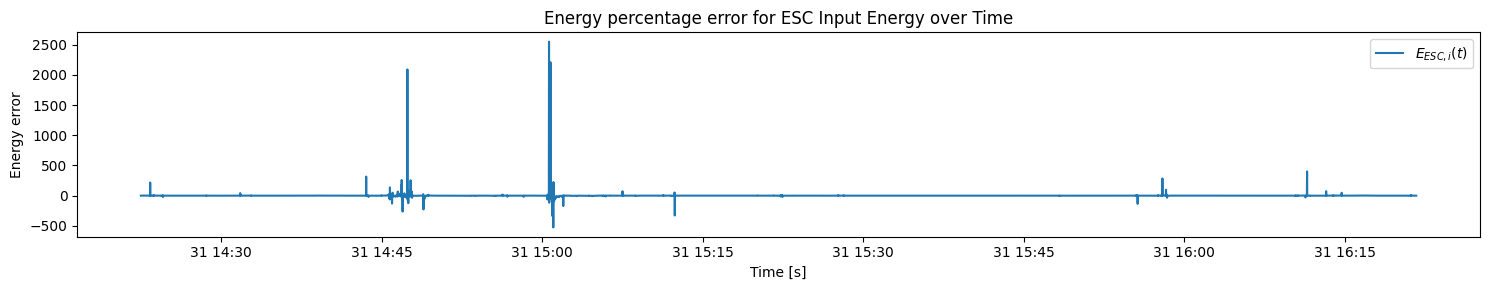

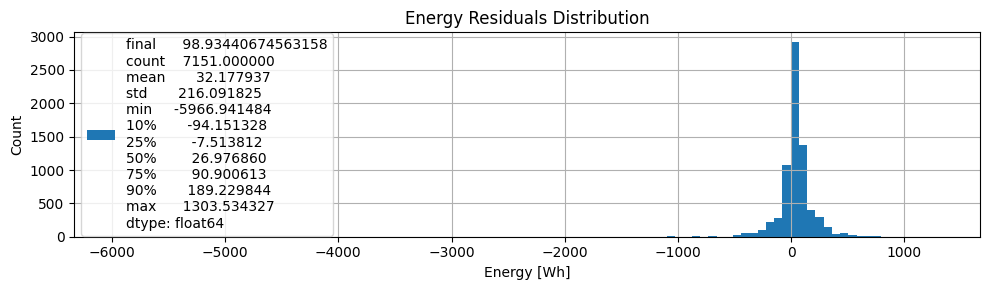

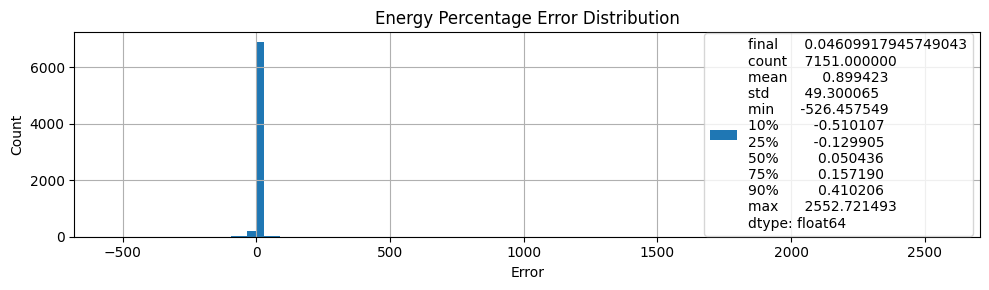

In [34]:
from scipy.integrate import cumtrapz

# df = df.iloc[:-500]

def compute_energy(time, power, initial=0):
    seconds_in_one_hour = 3600
    return cumtrapz(power, time, initial=initial) / seconds_in_one_hour # units: Watt-hour

# Time array
T = (df.index[1] - df.index[0]).to_numpy().astype(np.float64) * 1e-9   # simulation time in seconds
lenT = len(df.index)
T = np.linspace(0, lenT * T, lenT, endpoint=False)  # Recreate the time array because of numerical issues from the index datetime to float transformation

# Inputs
U = df[['esc_dt', 'batt_v']].to_numpy().T

df_model = ct.input_output_response(
    Propulsion.build(result.params.valuesdict()),
    T=T,
    U=U,
    solve_ivp_kwargs={"method": "Radau"},
).to_pandas()

df['esc_p_in'] = df['esc_i_in'] * df['batt_v']
df_model['esc_p_in'] = df_model['Ii'].to_numpy() * df_model['Vi'].to_numpy()

residuals = df['esc_i_in'].to_numpy() - df_model['Ii']
rmse = np.sqrt(np.mean(np.square(residuals)))
mae = np.mean(np.abs(residuals))

plt.figure(figsize=(15, 3))
plt.plot(df.index, df['esc_i_in'], label='$I(Throttle(t))$ (data)')
plt.plot(df.index, df_model['Ii'], '--', label='$I(Throttle(t))$ (model)')
plt.xlabel('Time [s]')
plt.ylabel('ESC Current [A]')
plt.legend(loc=1)
plt.suptitle(f"Propulsion Model Fitting. MAE: {mae}, RMSE: {rmse}")
plt.tight_layout()
plt.show()

residuals = df['motor_w'].to_numpy() - df_model['w']
rmse = np.sqrt(np.mean(np.square(residuals)))
mae = np.mean(np.abs(residuals))

plt.figure(figsize=(15, 3))
plt.plot(df.index, df['motor_w'], label='$w(Throttle(t))$ (data)')
plt.plot(df.index, df_model['w'], '--', label='$w(Throttle(t))$ (model)')
plt.xlabel('Time [s]')
plt.ylabel('Motor Angular Speed [rad/s]')
plt.legend(loc=1)
plt.suptitle(f"Propulsion Model Fitting. MAE: {mae}, RMSE: {rmse}")
plt.tight_layout()
plt.show()

residuals = df['esc_p_in'].to_numpy() - df_model['esc_p_in']
rmse = np.sqrt(np.mean(np.square(residuals)))
mae = np.mean(np.abs(residuals))

plt.figure(figsize=(15, 3))
plt.plot(df.index, df['esc_p_in'], label='$P(Throttle(t))$ (data)')
plt.plot(df.index, df_model['esc_p_in'], '--', label='$P(Throttle(t))$ (model)')
plt.xlabel('Time [s]')
plt.ylabel('ESC Current [A]')
plt.legend(loc=1)
plt.suptitle(f"Propulsion Model Fitting. MAE: {mae}, RMSE: {rmse}")
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,3))
plt.scatter(df['esc_dt'], df['esc_p_in'], label='data', s=0.2)
plt.scatter(df['esc_dt'], df_model['esc_p_in'], label='model', s=0.5)
plt.xlabel('Throttle [%]')
plt.ylabel('Power [W]')
plt.legend(loc=0)
plt.suptitle('Power vs Throttle')
plt.ylim([0,6000])
plt.tight_layout()
plt.show()

df['esc_ei'] = compute_energy(df['esc_p_in'].to_numpy(), T)
df_model['esc_ei'] = compute_energy(df_model['esc_p_in'].to_numpy(), T)

plt.figure(figsize=(15,3))
plt.plot(df.index, df['esc_ei'], label='$E_{ESC,i}(t)$ (data)')
plt.plot(df.index, df_model['esc_ei'], '--', label='$E_{ESC,i}(t)$ (model)')
plt.xlabel('Time [s]')
plt.ylabel('Energy [Wh]')
plt.title('ESC Input Energy over Time')
plt.legend(loc=1)
plt.tight_layout()
plt.show()

energy_residuals = (df['esc_ei'].to_numpy() - df_model['esc_ei'].to_numpy())
plt.figure(figsize=(15,3))
plt.plot(df.index, energy_residuals, label='$E_{ESC,i}(t)$')
plt.xlabel('Time [s]')
plt.ylabel('Energy [Wh]')
plt.title('Residuals for ESC Input Energy over Time')
plt.legend(loc=1)
plt.tight_layout()
plt.show()

energy_percent_error = np.divide(df['esc_ei'].to_numpy() -df_model['esc_ei'].to_numpy(), df['esc_ei'].to_numpy(), out=np.zeros_like(df_model['esc_ei'].to_numpy()), where=df['esc_ei'].to_numpy() != 0)
energy_percent_error[0] = 0

plt.figure(figsize=(15,3))
plt.plot(df.index, energy_percent_error, label='$E_{ESC,i}(t)$')
plt.xlabel('Time [s]')
plt.ylabel('Energy error')
plt.title('Energy percentage error for ESC Input Energy over Time')
plt.legend(loc=1)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3))
label = f'final      {energy_residuals[-1]}\n{str(pd.Series(energy_residuals).describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]))}'
plt.hist(energy_residuals, bins=100, label=label)
plt.title('Energy Residuals Distribution')
plt.xlabel('Energy [Wh]')
plt.ylabel('Count')
plt.grid(True)
plt.legend(loc=6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3))
label = f'final      {energy_percent_error[-1]}\n{str(pd.Series(energy_percent_error).describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]))}'
plt.hist(energy_percent_error, bins=100, label=label)
plt.title('Energy Percentage Error Distribution')
plt.xlabel('Error')
plt.ylabel('Count')
plt.grid(True)
plt.legend(loc=5)
plt.tight_layout()
plt.show()

In [36]:
a = 98
a / df['esc_ei'].iloc[-1]

0.04566378609263295

'original columns:'

Index(['Battery Pack Voltage', 'Pilot Duty Cycle', 'Pilot Motor On',
       'Pilot Boat On', 'ESC Duty Cycle', 'Motor Angular Speed',
       'MPPT 1 Input Voltage', 'MPPT 2 Input Voltage', 'MPPT 3 Input Voltage',
       'MPPT 4 Input Voltage', 'MPPT 1 Output Voltage',
       'MPPT 2 Output Voltage', 'MPPT 3 Output Voltage',
       'MPPT 4 Output Voltage', 'MPPT 1 Input Current', 'MPPT 2 Input Current',
       'MPPT 3 Input Current', 'MPPT 4 Input Current', 'MPPT 1 Duty Cycle',
       'MPPT 2 Duty Cycle', 'MPPT 3 Duty Cycle', 'MPPT 4 Duty Cycle',
       'MPPT 1 Input Power', 'MPPT 2 Input Power', 'MPPT 3 Input Power',
       'MPPT 4 Input Power', 'MPPTs Input Power', 'MPPT 1 Output Current',
       'MPPT 2 Output Current', 'MPPT 3 Output Current',
       'MPPT 4 Output Current', 'MPPTs Output Current', 'MPPT 1 Output Power',
       'MPPT 2 Output Power', 'MPPT 3 Output Power', 'MPPT 4 Output Power',
       'MPPTs Output Power', 'Battery Current', 'Battery Power',
       'ESC Input Curre

'renamed columns:'

{'Battery Pack Voltage': 'batt_v',
 'Battery Current': 'batt_i',
 'ESC Duty Cycle': 'esc_dt',
 'Motor Angular Speed': 'motor_w',
 'ESC Input Power': 'esc_p_in',
 'ESC Input Current': 'esc_i_in'}

'selected columns:'

Index(['batt_v', 'batt_i', 'esc_dt', 'motor_w', 'esc_p_in', 'esc_i_in'], dtype='object')

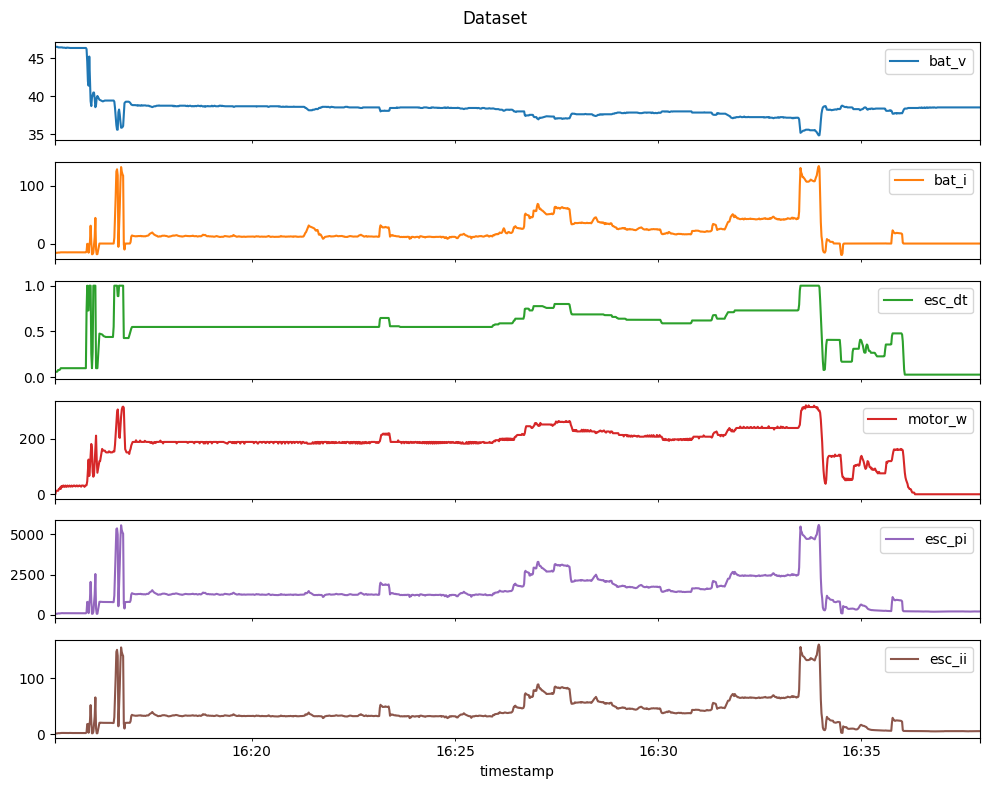

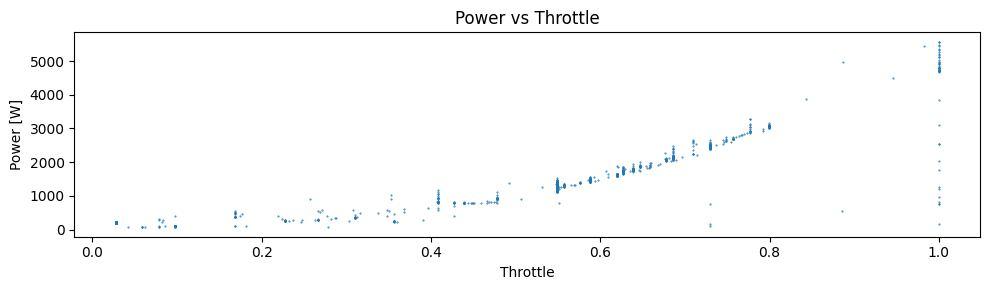

In [37]:
import vaex

event = events.loc['05.Curta']
start = (event['start']).tz_convert(None)
end = (event['end'] + pd.Timedelta(minutes=5)).tz_convert(None)

df = vaex.from_csv("../../../models/2020/boat_data_1s.csv").to_pandas_df()
# df = vaex.from_csv("../../../models/2020/boat_data_100ms.csv").to_pandas_df()
df["timestamp"] = pd.DatetimeIndex(df["timestamp"]).tz_convert(None)
df = df.set_index("timestamp")
display('original columns:', df.columns)

renamed_columns = {
    'Battery Pack Voltage': 'batt_v',
    'Battery Current': 'batt_i',
    'ESC Duty Cycle': 'esc_dt',
    'Motor Angular Speed': 'motor_w',
    'ESC Input Power': 'esc_p_in',
    'ESC Input Current': 'esc_i_in',
}
display('renamed columns:', renamed_columns)

df = df.loc[
    (df.index >= start) & (df.index <= end),
    renamed_columns.keys(),
].rename(columns=renamed_columns)

display('selected columns:', df.columns)

df = df.interpolate(method="time")
df = df.resample('1s').ffill()

df.plot(subplots=True, figsize=(10, 8))
plt.suptitle('Dataset')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3))
plt.title('Power vs Throttle')
plt.xlabel('Throttle')
plt.ylabel('Power [W]')
plt.scatter(df['esc_dt'], df['esc_p_in'], s=0.2)
plt.tight_layout()
plt.show()


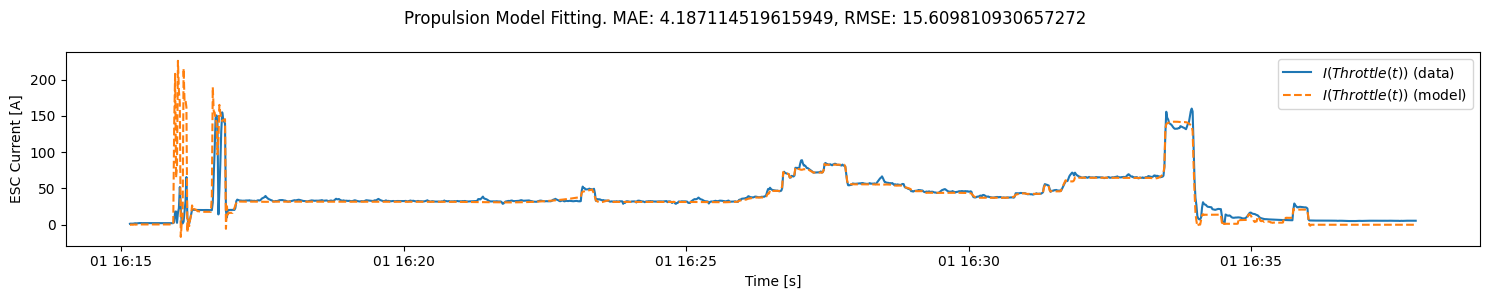

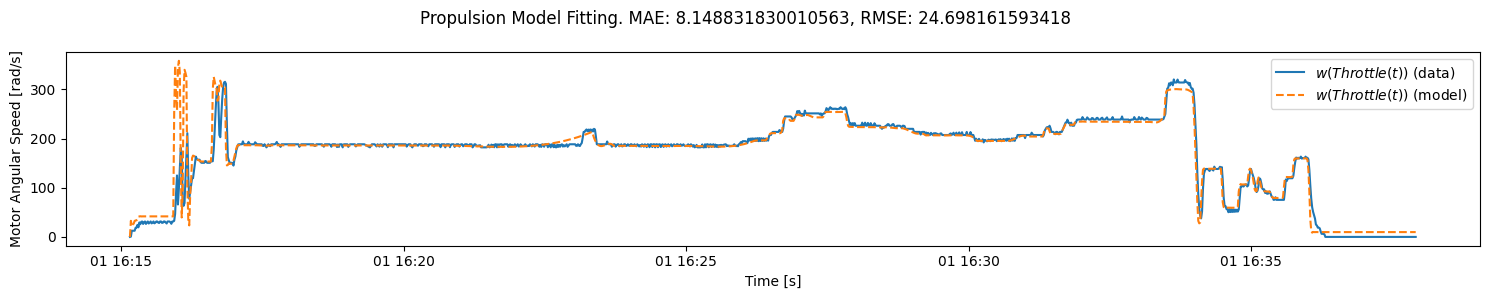

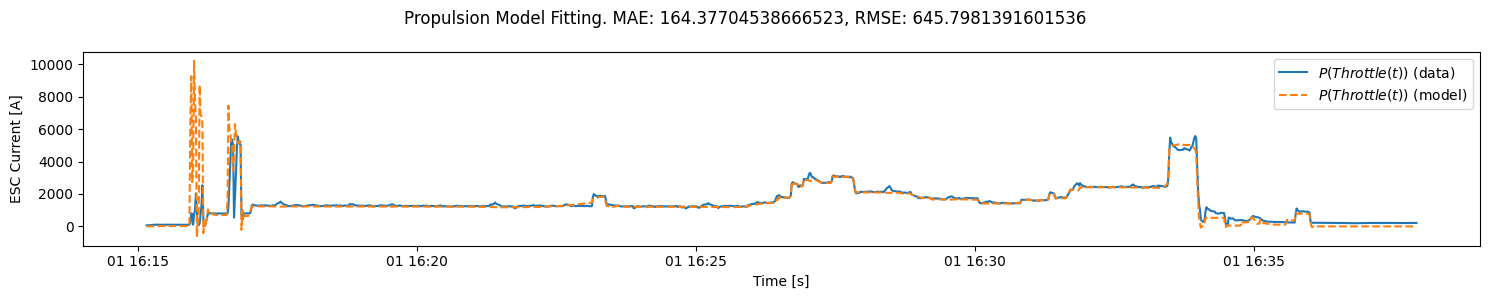

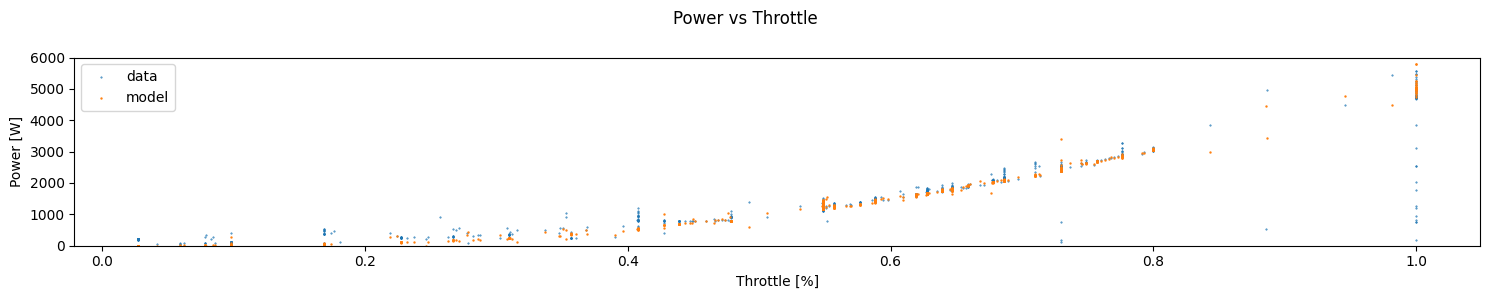

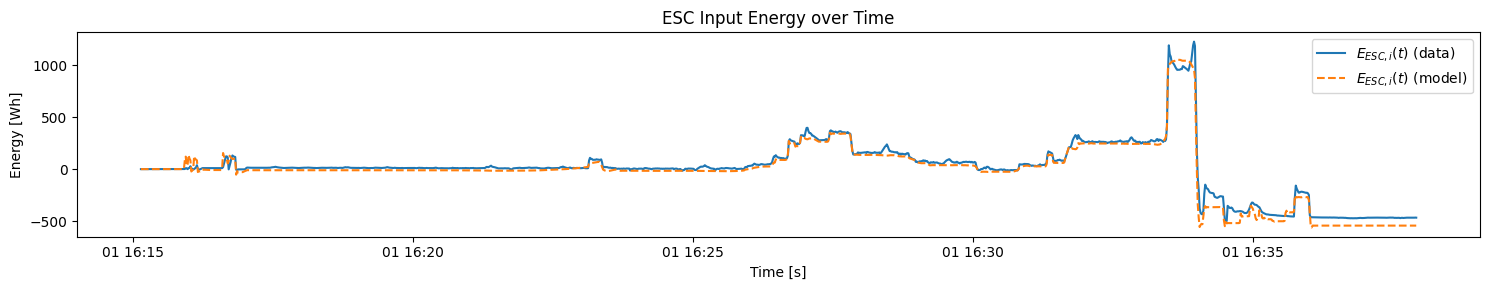

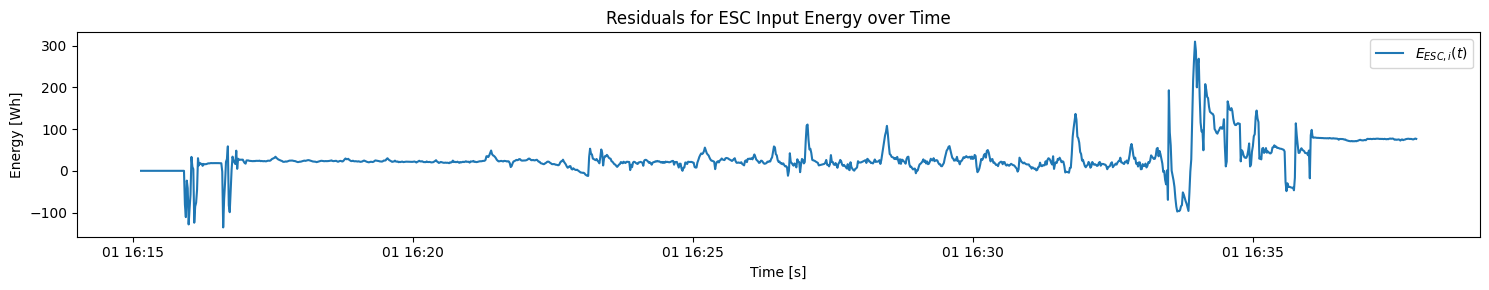

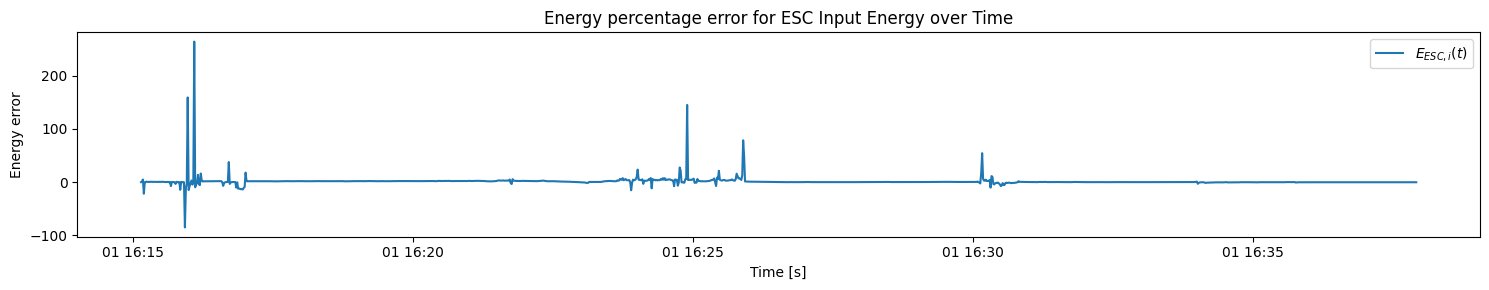

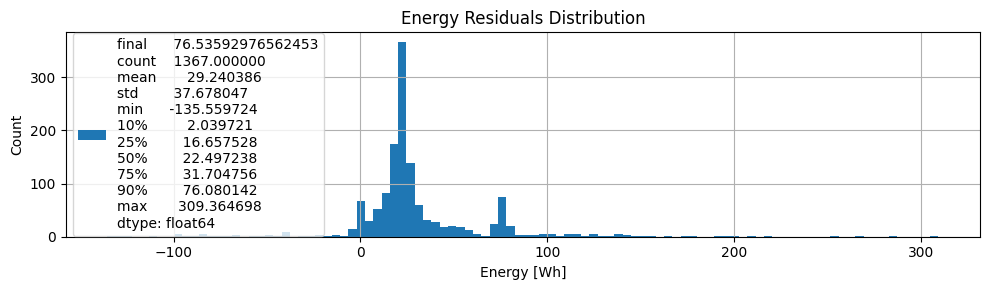

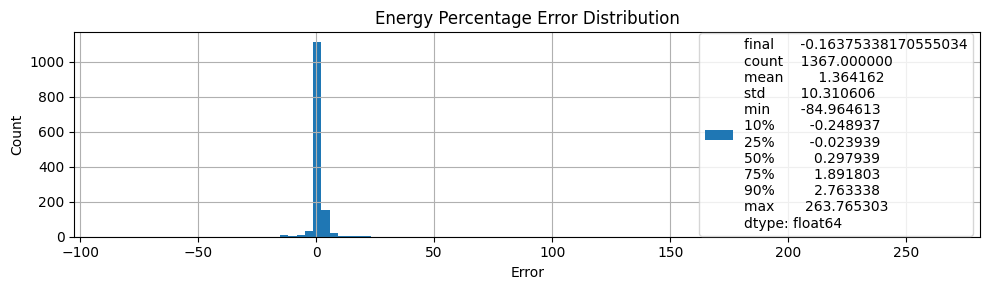

In [38]:
T = (df.index[1] - df.index[0]).to_numpy().astype(np.float64) * 1e-9   # simulation time in seconds
lenT = len(df.index)
T = np.linspace(0, lenT * T, lenT, endpoint=False)  # Recreate the time array because of numerical issues from the index datetime to float transformation

# Inputs
U = df[['esc_dt', 'batt_v']].to_numpy().T

df_model = ct.input_output_response(
    Propulsion.build(result.params.valuesdict()),
    T=T,
    U=U,
    solve_ivp_kwargs={"method": "Radau"},
).to_pandas()

df['esc_p_in'] = df['esc_i_in'] * df['batt_v']
df_model['esc_p_in'] = df_model['Ii'].to_numpy() * df_model['Vi'].to_numpy()

residuals = df['esc_i_in'].to_numpy() - df_model['Ii']
rmse = np.sqrt(np.mean(np.square(residuals)))
mae = np.mean(np.abs(residuals))

plt.figure(figsize=(15, 3))
plt.plot(df.index, df['esc_i_in'], label='$I(Throttle(t))$ (data)')
plt.plot(df.index, df_model['Ii'], '--', label='$I(Throttle(t))$ (model)')
plt.xlabel('Time [s]')
plt.ylabel('ESC Current [A]')
plt.legend(loc=1)
plt.suptitle(f"Propulsion Model Fitting. MAE: {mae}, RMSE: {rmse}")
plt.tight_layout()
plt.show()

residuals = df['motor_w'].to_numpy() - df_model['w']
rmse = np.sqrt(np.mean(np.square(residuals)))
mae = np.mean(np.abs(residuals))

plt.figure(figsize=(15, 3))
plt.plot(df.index, df['motor_w'], label='$w(Throttle(t))$ (data)')
plt.plot(df.index, df_model['w'], '--', label='$w(Throttle(t))$ (model)')
plt.xlabel('Time [s]')
plt.ylabel('Motor Angular Speed [rad/s]')
plt.legend(loc=1)
plt.suptitle(f"Propulsion Model Fitting. MAE: {mae}, RMSE: {rmse}")
plt.tight_layout()
plt.show()

residuals = df['esc_p_in'].to_numpy() - df_model['esc_p_in']
rmse = np.sqrt(np.mean(np.square(residuals)))
mae = np.mean(np.abs(residuals))

plt.figure(figsize=(15, 3))
plt.plot(df.index, df['esc_p_in'], label='$P(Throttle(t))$ (data)')
plt.plot(df.index, df_model['esc_p_in'], '--', label='$P(Throttle(t))$ (model)')
plt.xlabel('Time [s]')
plt.ylabel('ESC Current [A]')
plt.legend(loc=1)
plt.suptitle(f"Propulsion Model Fitting. MAE: {mae}, RMSE: {rmse}")
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,3))
plt.scatter(df['esc_dt'], df['esc_p_in'], label='data', s=0.2)
plt.scatter(df['esc_dt'], df_model['esc_p_in'], label='model', s=0.5)
plt.xlabel('Throttle [%]')
plt.ylabel('Power [W]')
plt.legend(loc=0)
plt.suptitle('Power vs Throttle')
plt.ylim([0,6000])
plt.tight_layout()
plt.show()

df['esc_ei'] = compute_energy(df['esc_p_in'].to_numpy(), T)
df_model['esc_ei'] = compute_energy(df_model['esc_p_in'].to_numpy(), T)

plt.figure(figsize=(15,3))
plt.plot(df.index, df['esc_ei'], label='$E_{ESC,i}(t)$ (data)')
plt.plot(df.index, df_model['esc_ei'], '--', label='$E_{ESC,i}(t)$ (model)')
plt.xlabel('Time [s]')
plt.ylabel('Energy [Wh]')
plt.title('ESC Input Energy over Time')
plt.legend(loc=1)
plt.tight_layout()
plt.show()

energy_residuals = (df['esc_ei'].to_numpy() - df_model['esc_ei'].to_numpy())
plt.figure(figsize=(15,3))
plt.plot(df.index, energy_residuals, label='$E_{ESC,i}(t)$')
plt.xlabel('Time [s]')
plt.ylabel('Energy [Wh]')
plt.title('Residuals for ESC Input Energy over Time')
plt.legend(loc=1)
plt.tight_layout()
plt.show()

energy_percent_error = np.divide(df['esc_ei'].to_numpy() -df_model['esc_ei'].to_numpy(), df['esc_ei'].to_numpy(), out=np.zeros_like(df_model['esc_ei'].to_numpy()), where=df['esc_ei'].to_numpy() != 0)
energy_percent_error[0] = 0

plt.figure(figsize=(15,3))
plt.plot(df.index, energy_percent_error, label='$E_{ESC,i}(t)$')
plt.xlabel('Time [s]')
plt.ylabel('Energy error')
plt.title('Energy percentage error for ESC Input Energy over Time')
plt.legend(loc=1)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3))
label = f'final      {energy_residuals[-1]}\n{str(pd.Series(energy_residuals).describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]))}'
plt.hist(energy_residuals, bins=100, label=label)
plt.title('Energy Residuals Distribution')
plt.xlabel('Energy [Wh]')
plt.ylabel('Count')
plt.grid(True)
plt.legend(loc=6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3))
label = f'final      {energy_percent_error[-1]}\n{str(pd.Series(energy_percent_error).describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]))}'
plt.hist(energy_percent_error, bins=100, label=label)
plt.title('Energy Percentage Error Distribution')
plt.xlabel('Error')
plt.ylabel('Count')
plt.grid(True)
plt.legend(loc=5)
plt.tight_layout()
plt.show()

In [40]:
a = 76
a / df['esc_ei'].iloc[-1]

-0.1626067266411064